In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
from datetime import timedelta
import json
import requests
import wordcloud

import plotly
import plotly.offline as ply
import plotly.graph_objs as go
ply.init_notebook_mode(connected=True)

---
## Load twitch emotes

In [269]:
# https://twitchemotes.com/apidocs
with open("./subscriber.json") as f:
    j = json.load(f)

In [68]:
j.keys()

dict_keys(['0', '18587270', '22253819', '14293484', '12519', '28914510', '11152602', '23971811', '23460970', '17429923', '25553391', '23580808', '12665', '27371338', '32179353', '8330235', '29578325', '14779612', '23735582', '23161357', '21794966', '37846210', '5521605', '9846758', '1', '8707283', '10332629', '21534457', '30080824', '2702425', '27686136', '2', '19107317', '22705677', '7236692', '19228601', '31723226', '25924287', '30080751', '30383713', '27924936', '10817445', '20694610', '23082675', '2261919', '25015411', '25013123', '38865198', '22365608', '8014563', '24991333', '18807342', '23057278', '20553964', '30080840', '13706856', '28064707', '22552479', '9013547', '21622667', '21030796', '14226214', '30923466', '13363719', '2941086', '22025290', '31606651', '30890834', '21931814', '17324860', '20773527', '24124090', '18730955', '497952', '35091336', '37524427', '26301881', '22168893', '9366602', '175419', '4221521', '8683614', '13460644', '21521869', '6611839', '30777889', '2

In [270]:
j["23082675"]

{'channel_name': 'cyepicx',
 'display_name': 'CyEPiCx',
 'channel_id': '23082675',
 'broadcaster_type': 'partner',
 'plans': {'$4.99': '62', '$9.99': '35668', '$24.99': '35669'},
 'emotes': [{'code': 'epicHeart', 'emoticon_set': 62, 'id': 6928},
  {'code': 'epicMug', 'emoticon_set': 62, 'id': 7010},
  {'code': 'epicRambo', 'emoticon_set': 62, 'id': 7043},
  {'code': 'epicPotato', 'emoticon_set': 62, 'id': 7045},
  {'code': 'epicSammy', 'emoticon_set': 62, 'id': 7495},
  {'code': 'epicFail', 'emoticon_set': 62, 'id': 15904},
  {'code': 'epicNation', 'emoticon_set': 62, 'id': 188067},
  {'code': 'epicBdlove', 'emoticon_set': 62, 'id': 658286},
  {'code': 'epicCheer', 'emoticon_set': 62, 'id': 675041},
  {'code': 'epicBob', 'emoticon_set': 62, 'id': 732302},
  {'code': 'epicSnow', 'emoticon_set': 35669, 'id': 658309}],
 'base_set_id': '62',
 'generated_at': '2019-04-29T17:21:27Z'}

### Extract emote codes from json

In [271]:
emotes = []
emote_ids = []
for channel_emotes in j.values():
    emotes += [emote["code"] for emote in channel_emotes["emotes"]]
    emote_ids += [emote["id"] for emote in channel_emotes["emotes"]]
emotes = pd.Series(emotes)
emote_ids = pd.Series(emote_ids)

In [279]:
global_emotes = pd.concat([emotes, emote_ids], axis=1)
global_emotes.columns = ["emote", "id"]
global_emotes.head()

emote  id
0        \:-?\)   1
1        \:-?\(   2
2         \:-?D   3
3      \&gt\;\(   4
4  \:-?[z|Z|\|]   5

### Filter out non-alphanumeric emotes

In [281]:
global_emotes = global_emotes[emotes.str.match("^\w+$")].sort_values(by="emote").reset_index(drop=True)
global_emotes.head()

emote     id
0       04s00  12294
1      04sAGS  12252
2      04sDDS  12253
3     04sFACE   5599
4  04sSitdown  12228

In [282]:
emotes_set = set(global_emotes["emote"])

In [284]:
global_emotes.to_csv("emotes.csv", index=False)

---
## Frankerface emotes

In [135]:
# https://api.frankerfacez.com/v1/emoticons?page=1
ff_url = "https://api.frankerfacez.com/v1/emoticons?sort=count-desc&page={}"

ff_emotes = []
for i in range(25):
    j = requests.get(ff_url.format(i+1)).json()
    ff_emotes += [emote["name"] for emote in j["emoticons"]]
ff_emotes = pd.Series(ff_emotes)

In [138]:
ff_emotes_set = set(ff_emotes)

In [137]:
ff_emotes.to_csv("ff_emotes.csv", index=False, header=False)

---
## BTTV Emotes

In [139]:
# https://api.betterttv.net/2/channels/quin69
bttv_url = "https://api.betterttv.net/2/channels/{}"
channel_name = "quin69"

j = requests.get(bttv_url.format(channel_name)).json()
bttv_emotes = pd.Series([emote["code"] for emote in j["emotes"]])

In [141]:
bttv_emotes_set = set(bttv_emotes)

In [142]:
bttv_emotes.to_csv("bttv_emotes.csv", index=False, header=False)

### Load pre-processed emote lists

In [286]:
global_emotes = pd.read_csv("./emotes.csv")
emotes_set = set(global_emotes.values[:,0])
bttv_emotes = pd.read_csv("./bttv_emotes.csv", header=None)
bttv_emotes_set = set(bttv_emotes.values[:,0])
ff_emotes = pd.read_csv("./ff_emotes.csv", header=None)
ff_emotes_set = set(ff_emotes.values[:,0])

---
# Load Chat Messages

In [8]:
channel = "mdldisney"

In [340]:
messages = pd.read_csv("./chat_messages_{}.csv".format(channel), encoding="utf8", na_filter=False,
                       header=None, names=["timestamp", "username", "message"])

messages["timestamp"] = pd.to_datetime(messages["timestamp"], unit="ms") + timedelta(hours=1)

# messages = messages[messages["timestamp"] > "2019-05-10 17:59:32.538"]
messages.head()


timestamp       username                     message
0 2019-05-10 18:17:20.887     limiti_ess     JESUS THIS NSFW CONTENT
1 2019-05-10 18:17:21.319  strawhatfleet     BRING THE BULLY HUNTERS
2 2019-05-10 18:17:22.033      plankt0n_  Montage of skillshots LMAO
3 2019-05-10 18:17:22.321       dabzdaog               This game LUL
4 2019-05-10 18:17:22.543      pyamasxxx                         322

In [7]:
time_interval = "1m"

In [341]:
chat_emotes_interval = pd.DataFrame(columns=["timestamp", "emotes"])
for i, group in messages.groupby((messages.timestamp - messages.timestamp.values[0]).astype('timedelta64[{}]'.format(time_interval))):
    group = group.reset_index(drop=True)
    
    freqs = pd.Series(group["message"].str.split().sum()).value_counts()

    valid_freqs = freqs[freqs.index.isin(emotes_set | bttv_emotes_set | ff_emotes_set)].reset_index().values
    
    freqs_df = pd.DataFrame([[group.loc[0, "timestamp"], valid_freqs]], columns=["timestamp", "emotes"])
    chat_emotes_interval = chat_emotes_interval.append(freqs_df, ignore_index=True)
    
    print(i)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0


In [126]:
chat_emotes_interval

timestamp                                             emotes
0  2019-05-10 17:47:01.975  [[LUL, 97], [4Head, 23], [PJSalt, 22], [TriHar...
1  2019-05-10 17:47:32.129  [[LUL, 104], [TriHard, 41], [4Head, 22], [LULW...
2  2019-05-10 17:48:02.722  [[FeelsBirthdayMan, 70], [LUL, 53], [Kreygasm,...
3  2019-05-10 17:48:33.246  [[FeelsBirthdayMan, 95], [LUL, 45], [Clap, 14]...
4  2019-05-10 17:49:02.056  [[LUL, 45], [FeelsBirthdayMan, 15], [BibleThum...
5  2019-05-10 17:49:32.140  [[LUL, 74], [LULW, 21], [Clap, 15], [OMEGALUL,...
6  2019-05-10 17:50:02.068  [[LUL, 60], [LULW, 18], [PJSalt, 10], [foggedF...
7  2019-05-10 17:50:32.141  [[LUL, 103], [TriHard, 53], [FeelsBirthdayMan,...
8  2019-05-10 17:51:02.084  [[TriHard, 43], [LUL, 36], [LULW, 19], [WutFac...
9  2019-05-10 17:51:32.697  [[LUL, 46], [LULW, 8], [FeelsBadMan, 7], [Pog,...
10 2019-05-10 17:52:02.163  [[LUL, 53], [TriHard, 30], [OMEGALUL, 13], [LU...
11 2019-05-10 17:52:32.036  [[LUL, 50], [LULW, 17], [EleGiggle, 8], [BabyR...
12 2019-05-10 17:53:02.523  [[LUL, 32], [FeelsBadMan, 13], [TriHard, 7], [...
13 2019-05-10 17:53:33.819  [[LUL, 22], [TriHard, 13], [cmonBruh, 12], [Fe...
14 2019-05-10 17:54:02.357  [[TriHard, 26], [cmonBruh, 21], [LUL, 18], [Ka...
15 2019-05-10 17:54:33.276  [[LUL, 21], [TriHard, 16], [LULW, 14], [SoBaye...
16 2019-05-10 17:55:01.979  [[TriHard, 30], [LUL, 29], [KappaPride, 12], [...
17 2019-05-10 17:55:32.311  [[TriHard, 40], [LUL, 23], [KappaPride, 17], [...
18 2019-05-10 17:56:02.191  [[TriHard, 15], [LUL, 10], [cmonBruh, 9], [Cla...
19 2019-05-10 17:56:33.493  [[LUL, 25], [SoBayed, 16], [TriHard, 16], [LUL...
20 2019-05-10 17:57:02.103  [[TriHard, 49], [LUL, 16], [PogChamp, 7], [OME...
21 2019-05-10 17:57:32.977  [[LUL, 52], [Pog, 27], [LULW, 25], [TriHard, 1...
22 2019-05-10 17:58:02.004  [[LUL, 44], [LULW, 16], [TriHard, 14], [RIP, 1...
23 2019-05-10 17:58:32.398  [[LUL, 27], [EleGiggle, 8], [BabyRage, 7], [Ka...
24 2019-05-10 17:59:02.011  [[TriHard, 21], [LUL, 11], [Clap, 10], [SoBaye...
25 2019-05-10 17:59:32.538  [[TriHard, 20], [Clap, 7], [cmonBruh, 3], [LUL...

---

In [150]:
len(emotes_set | bttv_emotes_set | ff_emotes_set)

1010660

---
## Visualising

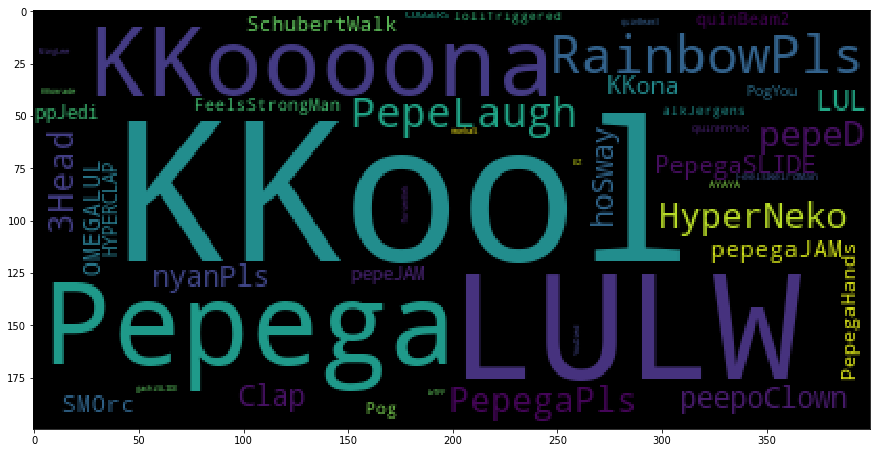

In [22]:
cloud = wordcloud.WordCloud().generate_from_frequencies(dict(chat_emotes_interval.loc[0,"emotes"]))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)

In [343]:
# Set of all emotes for the sparse vectors
tmp_em_set = pd.Series(chat_emotes_interval["emotes"].apply(lambda x: list(np.array(x)[:,0])).sum()).value_counts()

In [344]:
df = pd.DataFrame(columns=tmp_em_set.index)
for row in chat_emotes_interval["emotes"]:
    # Create sparse vectors for each interval
    df = df.append(pd.Series(dict(row)), ignore_index=True)
    
df = df.fillna(0).astype(int)
df = pd.concat([chat_emotes_interval["timestamp"], df], axis=1)

In [345]:
df.head()

timestamp  LUL  Pog  PogChamp  Clap  monkaS  BabyRage  4Head  \
0 2019-05-10 18:17:20.887  104    5         3     0      20         0      1   
1 2019-05-10 18:18:20.978  137   10         6     1      67         1      3   
2 2019-05-10 18:19:21.173  165    4         4     4       1         0      2   
3 2019-05-10 18:20:21.171  175    6         4    10      28         0      5   
4 2019-05-10 18:21:21.225  139    2         3     1       3         0      0   

   Kappa  WutFace   ...     moon2WOW  s1lverEZ  rvgeFire  rooW  xqcArm2  \
0      1        3   ...            0         0         0     0        0   
1      9        1   ...            0         0         0     0        0   
2     14        1   ...            0         0         0     0        0   
3     14       11   ...            0         0         0     0        0   
4      2        1   ...            0         0         0     0        0   

   singsingLUL  lacAPERZ  PokCroagunk  asmonL  amiloP2  
0            0         0            0       0        0  
1            0         0            0       0        0  
2            0         0            0       0        0  
3            0         0            0       0        0  
4            0         0            0       0        0  

[5 rows x 718 columns]

In [346]:
# append
# with open("./emotes_{}_{}.csv".format(channel, time_interval), "a") as f:
#     df.to_csv(f, index=False, header=False)

# new file
df.to_csv("./emotes_{}_{}.csv".format(channel, time_interval), index=False, )

### Convert to long format

In [3]:
# Melt table
df_long = df.melt(id_vars=["timestamp"], var_name="emote", value_name="count")
# Drop 0 values
df_long = df_long.loc[df_long["count"] > 0,:]
# Sort by time -> count -> emote
df_long = df_long.sort_values(["timestamp", "count", "emote"], ascending=[True, False, True]).reset_index(drop=True)

In [5]:
df_long

timestamp            emote  count
0     2019-05-10 18:17:20.887              LUL    104
1     2019-05-10 18:17:20.887           monkaS     20
2     2019-05-10 18:17:20.887          SoBayed     11
3     2019-05-10 18:17:20.887       BibleThump      9
4     2019-05-10 18:17:20.887  ResidentSleeper      8
5     2019-05-10 18:17:20.887         DansGame      6
6     2019-05-10 18:17:20.887        EleGiggle      6
7     2019-05-10 18:17:20.887     FeelsGoodMan      6
8     2019-05-10 18:17:20.887              Pog      5
9     2019-05-10 18:17:20.887           Pepega      4
10    2019-05-10 18:17:20.887          FBCatch      3
11    2019-05-10 18:17:20.887         PogChamp      3
12    2019-05-10 18:17:20.887          WutFace      3
13    2019-05-10 18:17:20.887            anne7      3
14    2019-05-10 18:17:20.887           ibiLiq      3
15    2019-05-10 18:17:20.887         Kreygasm      2
16    2019-05-10 18:17:20.887             LULW      2
17    2019-05-10 18:17:20.887         OMEGALUL      2
18    2019-05-10 18:17:20.887        SeemsGood      2
19    2019-05-10 18:17:20.887         cmonBruh      2
20    2019-05-10 18:17:20.887        kuruOMEGA      2
21    2019-05-10 18:17:20.887            200IQ      1
22    2019-05-10 18:17:20.887            4Head      1
23    2019-05-10 18:17:20.887      FeelsBadMan      1
24    2019-05-10 18:17:20.887            Kappa      1
25    2019-05-10 18:17:20.887         lowcoRIP      1
26    2019-05-10 18:17:20.887          pepeJAM      1
27    2019-05-10 18:18:20.978              LUL    137
28    2019-05-10 18:18:20.978           monkaS     67
29    2019-05-10 18:18:20.978       BibleThump     24
...                       ...              ...    ...
6835  2019-05-10 21:46:21.402             sumE      3
6836  2019-05-10 21:46:21.402             sumW      3
6837  2019-05-10 21:46:21.402          Ricardo      2
6838  2019-05-10 21:46:21.402         cmonBruh      2
6839  2019-05-10 21:46:21.402           monkaS      2
6840  2019-05-10 21:46:21.402          HandsUp      1
6841  2019-05-10 21:46:21.402    HolidayCookie      1
6842  2019-05-10 21:46:21.402  HolidayOrnament      1
6843  2019-05-10 21:46:21.402           KonCha      1
6844  2019-05-10 21:46:21.402           OpieOP      1
6845  2019-05-10 21:46:21.402              POG      1
6846  2019-05-10 21:46:21.402         PixelBob      1
6847  2019-05-10 21:46:21.402  ResidentSleeper      1
6848  2019-05-10 21:46:21.402        ThunBeast      1
6849  2019-05-10 21:46:21.402           VoHiYo      1
6850  2019-05-10 21:46:21.402        admiralC1      1
6851  2019-05-10 21:46:21.402        admiralC2      1
6852  2019-05-10 21:46:21.402        admiralC3      1
6853  2019-05-10 21:46:21.402        admiralC4      1
6854  2019-05-10 21:46:21.402         admiralG      1
6855  2019-05-10 21:46:21.402         admiralV      1
6856  2019-05-10 21:46:21.402           asmonL      1
6857  2019-05-10 21:46:21.402     doctorWARCRY      1
6858  2019-05-10 21:46:21.402   drunkm3Stinkin      1
6859  2019-05-10 21:46:21.402          forsenH      1
6860  2019-05-10 21:46:21.402         frivElmo      1
6861  2019-05-10 21:46:21.402           monakS      1
6862  2019-05-10 21:46:21.402           moon2L      1
6863  2019-05-10 21:46:21.402         nikkisHm      1
6864  2019-05-10 21:46:21.402        nikkisLul      1

[6865 rows x 3 columns]

In [9]:
df_long.to_csv("./emotes_{}_{}_long.csv".format(channel, time_interval), index=False)

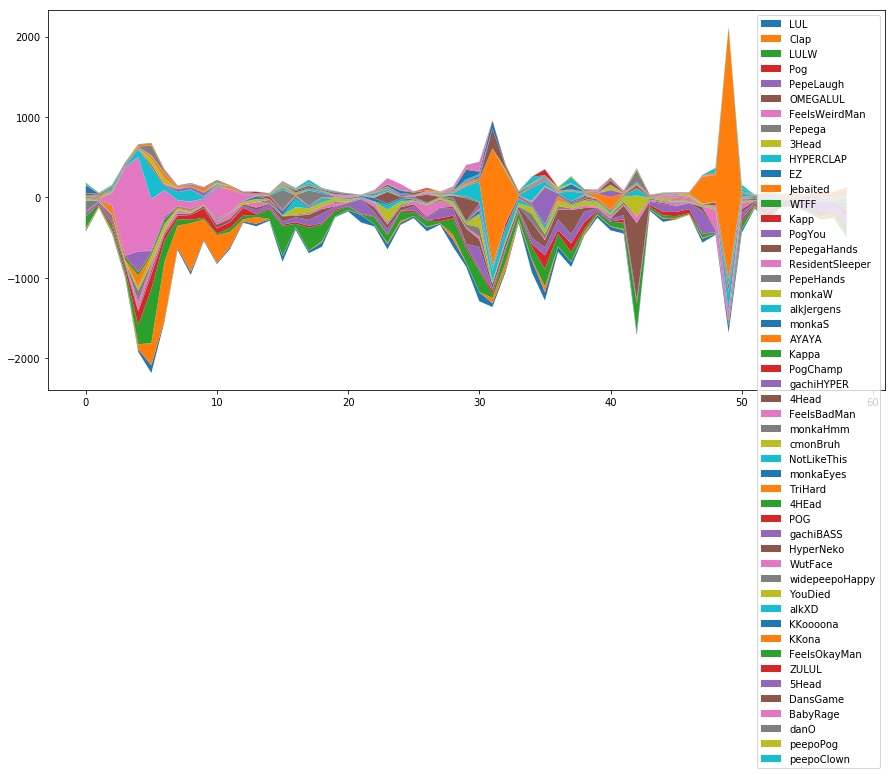

In [26]:
plot_df = df.iloc[:, :50]
fig = plt.figure(figsize=(15, 7), )
_ = plt.stackplot(range(len(df)), plot_df.T.fillna(0), baseline="wiggle")
plt.legend(plot_df.columns, )

In [59]:
traces = []

for col in df.columns[:50]:
    traces.append({
        "x": list(range(len(df))),
        "y": df[col],
        "stackgroup": "one",
        "name": col,
        "mode": "lines",
        "line": {"width":0},
        "hoverinfo": "y+name",
        "hoveron": "fills",
    })

In [60]:
ply.iplot({
    "data": traces,
    "layout": {
        "xaxis": {"title": "Time"},
    }
})

---
# Joy Plot

In [347]:
# Spaces out the data into rows
def to_joy_data(df, spacing=0.2, kind=0):
    # df.shape: (x, y)
    baselines = np.arange(len(df.columns)) * spacing
    return df + baselines

In [2]:
df = pd.read_csv("./emotes_mdldisney_1m.csv")
# Order emotes by their totals
col_order = df.iloc[:, 1:].sum().argsort().values[::-1]
df = df.iloc[:, np.concatenate([[0], (col_order)+1])]

In [349]:
percent_at_timestamp_df = (df.iloc[:, 1:].T / df.iloc[:, 1:].sum(axis=1)).T
percent_of_max_df = df.iloc[:, 1:] / df.iloc[:, 1:].max().max()

In [350]:
joy_df = to_joy_data(percent_of_max_df)

### With plotly

In [365]:
image_url = "https://static-cdn.jtvnw.net/emoticons/v1/{}/3.0"
image_width = 2000 * len(joy_df)

In [366]:
traces = []
images = []

# dummy trace to make autoscale keep images inside
traces.append({
    "x": [pd.to_datetime(df.loc[0, "timestamp"]) - pd.to_timedelta(image_width * 0.5, unit="ms"),],
    "y": [0,],
    "opacity": 0,
    "showlegend": False,
    "hoverinfo": "none",    
})


for i, col in enumerate(joy_df.iloc[:, :20].columns[::-1]):
    colour = plotly.colors.DEFAULT_PLOTLY_COLORS[i % len(plotly.colors.DEFAULT_PLOTLY_COLORS)]
    
    # Baseline traces
    traces.append({
        # Data
        "x": df["timestamp"],
        "y": np.repeat(joy_df[col].min(), len(joy_df[col])),
        
        # Line style
        "mode": "lines",
        "line": {"dash": "dash", "color": colour,},
        "opacity": 0.2,
        
        "showlegend": False,
        "hoverinfo": "none",
    })
    
    # Joy lines
    traces.append({
        # Data
        "x": df["timestamp"],
        "y": joy_df[col],
        
        # Tooltip info
        "name": col,
        "hoverinfo": "text",
        "text": ["{}<br>{}<br>Uses: {}".format(col, df.loc[i, "timestamp"], df.loc[i, col]) for i in range(len(df))],
        
        # Line style
        "mode": "lines",
        "line": {"shape": "spline", "smoothing": 1, "color": colour,},
    })
    
    # Images for each line
    try:
        url = image_url.format(global_emotes.loc[global_emotes["emote"]==col, "id"].iloc[0])
    except IndexError:
        url = None
    
    images.append({
        "source": url,
        # x position in timestamp format
        "x": pd.to_datetime(df.loc[0, "timestamp"]) - pd.to_timedelta(image_width * 1.5, unit="ms"),
        "y": joy_df[col].min() + 0.2,
        "sizex": image_width,
        "sizey": image_width,
        "xref": "x",
        "yref": "y",
    })
        
        
    

ply.iplot({
    "data": traces,
    
    "layout": {
        "yaxis": {"showticklabels": False, "showgrid": False, "scaleanchor": "y", },
        "xaxis": {"title": "Time", "scaleanchor": "y", },
        "title": {"text": "Emotes for " + channel,},
#         "legend": {"traceorder": "reversed"},
        "hovermode": "closest",
        
        "images": images,
    }
})